<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/310_subj_prop.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(cap-subj-prop)=
# Inferenza su una proporzione

Questo capitolo ha lo scopo di introdurre l'inferenza bayesiana utilizzando come esempio il modello binomiale. Inizieremo analizzando il caso in cui la distribuzione a priori è discreta e successivamente esploreremo il caso in cui la distribuzione a priori è continua (per un approfondimento, si veda il capitolo 7 del libro di {cite:t}`albert_2019prob`). 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import arviz as az
import seaborn as sns
import scipy.stats as st

In [3]:
%matplotlib inline

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

## Inferenza bayesiana con una distribuzione a priori discreta 

La visione soggettivista della probabilità afferma che la probabilità di un evento, rappresentata dalla quantità sconosciuta $\theta$, può essere concepita come un'opinione soggettiva. Tale opinione dipende dalle nostre credenze iniziali e dalle nuove informazioni fornite dai dati osservati. In questo capitolo, vedremo come combinare le nostre credenze iniziali su $\theta$ con le evidenze fornite dai dati per giungere a una nuova credenza a posteriori su $\theta$. Utilizzando le distribuzioni di probabilità, sarà possibile pensare in termini soggettivi a delle quantità sconosciute come $\theta$, che può assumere valori compresi tra 0 e 1.

Attribuire un valore preciso come 0.5 a $\theta$ significherebbe assegnare alla probabilità dell'evento $\theta = 0.5$ il valore 1, ovvero saremmo assolutamente certi che $\theta$ abbia il valore 0.5. Tuttavia, questa posizione è troppo estrema, poiché non possiamo essere completamente certi del valore di una quantità sconosciuta come $\theta$. Invece, è più ragionevole pensare che $\theta$ possa assumere vari valori, e assegnare livelli diversi di certezza soggettiva a tali valori.

Ad esempio, possiamo considerare undici possibili valori che $\theta$ potrebbe assumere. In tal caso, invece di assegnare una probabilità del 100% a un singolo valore come 0.5, assegneremo un certo livello di certezza soggettiva a ciascuno dei 11 valori. Utilizzando le distribuzioni di probabilità, possiamo esprimere la nostra opinione soggettiva su $\theta$ in modo completo e preciso.


In [4]:
theta = np.linspace(0, 1, 11)
print(theta)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Se non abbiamo motivo per fare diversamente, possiamo assegnare a ciascun valore `theta` la stessa probabilità.

In [5]:
unif_distr_pdf = st.uniform.pdf(theta) / 11
unif_distr_pdf

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

Text(0, 0.5, 'Probabilità')

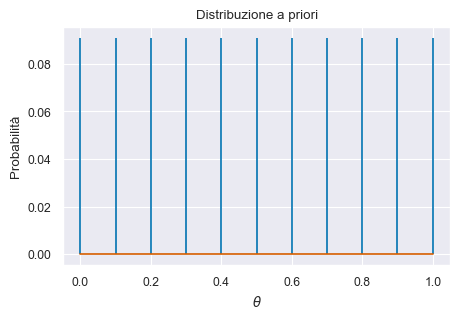

In [6]:
plt.stem(theta, unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità")

Oppure, per qualche ragione, potremmo pensare che i valori centrali della distribuzione di $\theta$ siamo più credibili dei valori estremi. Tale opinione soggettiva può essere descritta dalla seguente distribuzione di massa di probabilità.

Text(0, 0.5, 'Probabilità')

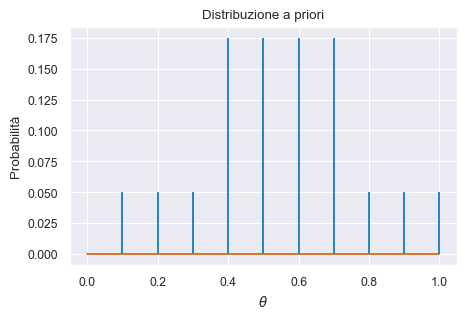

In [7]:
not_unif_distr_pdf = [0, 0.05, 0.05, 0.05, 0.175, 0.175, 0.175, 0.175, 0.05, 0.05, 0.05]
plt.stem(theta, not_unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità")

La prima distribuzione di probabilità è una distribuzione discreta uniforme perché assegna la stessa probabilità a ogni elemento dell'insieme discreto su cui è definita, ovvero i valori ${0, 0.1, 0.2, \dots, 1.0}$. Invece, la seconda distribuzione di probabilità è discreta ma non uniforme: si ritiene che sia più probabile che $\theta$ assuma un valore nell'insieme ${0.4, 0.5, 0.6, 0.7}$ piuttosto che nell'insieme ${0.1, 0.2, 0.3, 0.8, 0.9, 1.0}$.

Le credenze iniziali relative ai possibili valori di $\theta$ corrispondono alla *distribuzione a priori*. L'inferenza bayesiana "aggiorna" queste credenze a priori utilizzando le informazioni fornite dai dati. Queste informazioni sono combinate con le credenze a priori per $\theta$ mediante il teorema di Bayes, per ottenere la *distribuzione a posteriori*. La distribuzione a posteriori rappresenta la nostra credenza aggiornata sui possibili valori di $\theta$ dopo aver osservato i dati.

Supponiamo di aver osservato l'estrazione di 12 palline rosse in 20 estrazioni con rimessa da un'urna (ma, potremmo avere osservato 12 risultati "testa" in 20 lanci di una moneta). Per ottenere la distribuzione a posteriori, utilizziamo la seconda delle due distribuzioni a priori descritte in precedenza. Secondo il teorema di Bayes, la distribuzione a posteriori è data dal prodotto della verosimiglianza e della distribuzione a priori, diviso per una costante di normalizzazione:

$$
p(\theta \mid y) = \frac{p(y \mid \theta)p(\theta)}{p(y)}.
$$

Per trovare la funzione di verosimiglianza, $p(y \mid \theta)$, dobbiamo capire come sono stati generati i dati. Nel nostro caso, i dati corrispondono ai risultati di 20 estrazioni con rimessa da un'urna. Se l'estrazione è casuale con reinserimento, allora i dati (ossia 12 successi in 20 prove) possono essere considerati come il risultato di un esperimento casuale binomiale. Utilizzando Python, la funzione di verosimiglianza può essere ottenuta con la funzione `binom.pmf()`.

In [8]:
lk = st.binom.pmf(12, 20, theta)
lk

array([0.00000000e+00, 5.42259544e-08, 8.65659248e-05, 3.85928193e-03,
       3.54974396e-02, 1.20134354e-01, 1.79705788e-01, 1.14396740e-01,
       2.21608768e-02, 3.55776487e-04, 0.00000000e+00])

Per i 10 valori $\theta$ considerati, la funzione di verosimiglianza assume la forma indicata dalla figura seguente.

Text(0, 0.5, '$L(\\theta)$')

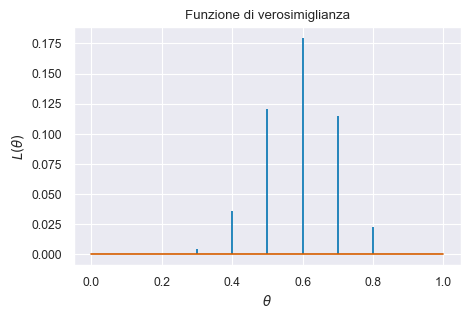

In [10]:
plt.stem(theta, lk, markerfmt=" ")
plt.title("Funzione di verosimiglianza")
plt.xlabel("$\\theta$")
plt.ylabel("$L(\\theta)$")

Per calcolare la distribuzione a posteriori, dobbiamo moltiplicare elemento per elemento il vettore contenente i valori della distribuzione a priori e il vettore contenente i valori della funzione di verosimiglianza. Successivamente, il prodotto deve essere normalizzato dividendo per la probabilità marginale dei dati $y$, che rappresenta una costante di normalizzazione.

Per la legge della probabilità totale, la probabilità marginale dei dati $y$ è pari alla somma dei prodotti tra la distribuzione a priori e la funzione di verosimiglianza.

In [9]:
np.sum(not_unif_distr_pdf * lk)

0.08002663388085006

La distribuzione a posteriori di $\theta$ è data dal prodotto della distribuzione a priori per la verosimiglianza diviso per la costante di normalizzazione (probabilità marginale dei dati).

In [12]:
post = (not_unif_distr_pdf * lk) / np.sum(not_unif_distr_pdf * lk)
print(post)

[0.00000000e+00 3.38799421e-08 5.40856966e-05 2.41124845e-03
 7.76248059e-02 2.62706437e-01 3.92975580e-01 2.50159584e-01
 1.38459383e-02 2.22286300e-04 0.00000000e+00]


Verifichiamo di avere ottenuto una distribuzione di massa di probabilità:

In [13]:
np.sum(post)

1.0000000000000002

Esaminiamo la distribuzione a posteriori di $\theta$.

Text(0, 0.5, 'Probabilità')

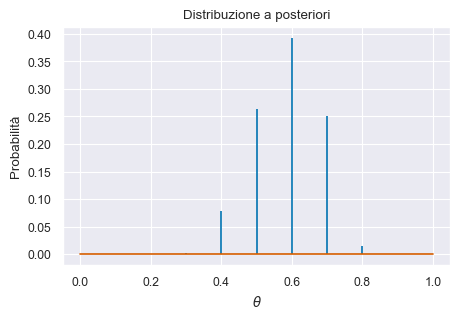

In [14]:
plt.stem(theta, post, markerfmt=" ")
plt.title("Distribuzione a posteriori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità")

Conoscendo la distribuzione a posteriori di $\theta$ diventa possibile calcolare altre quantità di interesse. Per esempio, la moda a posteriori di $\theta$ si ricava direttamente dal grafico precedente, e corrisponde a 0.6. La media a posteriori si trova con la formula del valore atteso delle v.c..

In [13]:
np.sum(theta * post)

0.5853112012901504

La varianza della distribuzione a posteriori è

In [14]:
np.sum(theta**2 * post) - (np.sum(theta * post)) ** 2


0.0088174094860623

Usando questo metodo possiamo trovare la distribuzione a posteriori di $\theta$ nel caso di qualunque distribuzione a priori discreta.

## Inferenza bayesiana con una distribuzione a priori continua 

Il caso di una distribuzione a priori discreta è stato discusso solo per scopi didattici. È importante notare che l'uso di una distribuzione a priori continua come la Beta è più appropriato poiché consente di rappresentare un'infinita gamma di possibili valori del parametro sconosciuto $\theta$, non limitandoci a un insieme discreto di valori. Inoltre, la distribuzione Beta ha il vantaggio di avere un supporto definito sull'intervallo $[0, 1]$, che è proprio l'intervallo di possibili valori per la proporzione $\theta$.

Ad esempio, la distribuzione Beta(2, 2) ha una forma simmetrica. Per valutare la distribuzione in corrispondenza di specifici valori, come 0.5, 0.8 e 1.2, possiamo utilizzare la funzione `beta.pdf`. Ad esempio, la densità di probabilità della distribuzione Beta(2, 2) in corrispondenza del valore 0.5 assume il valore 1.5, il che indica che i valori di $\theta$ intorno a 0.5 sono ritenuti più plausibili rispetto ai valori attorno a 0.8, dove la funzione assume il valore 0.96. La densità di probabilità Beta(2, 2) in corrispondenza del valore 1.2 è pari a 0, poiché il valore 1.2 non appartiene all'intervallo di definizione della distribuzione (0 e 1).

In [15]:
st.beta.pdf([0.5, 0.8, 1.2], 2, 2)

array([1.5 , 0.96, 0.  ])

Creiamo un grafico della funzione di densità $Beta(2, 2)$.

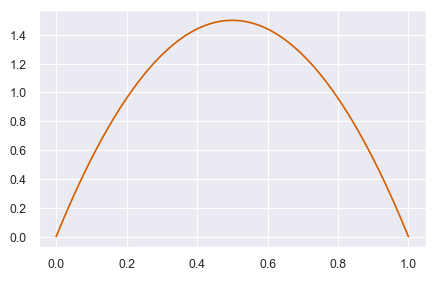

In [16]:
a = 2
b = 2
x = np.linspace(0, 1, 100)
plt.plot(x, st.beta.pdf(x, a, b), 'r-')

Valutiamo la funzione distribuzione di una $Beta(1, 1)$ in corrispondenza dei punti 0.5 e 0.8.

In [19]:
st.beta.cdf([0.5, 0.8], 2, 2)

array([0.5  , 0.896])

Calcoliamo la probabilità $P(0.5 < p < 0.8)$.

In [20]:
st.beta.cdf(0.8, 2, 2) - st.beta.cdf(0.5, 2, 2)

0.396

Troviamo i quantili di ordine 0.5 e 0.8.

In [21]:
st.beta.ppf([0.5, 0.8], 2, 2)

array([0.5       , 0.71285927])

Infine, simuliamo cinque valori casuali dalla distribuzione $Beta(2, 2)$. 

In [22]:
rng.beta(a=2, b=2, size=5)

array([0.35184838, 0.77696125, 0.71547708, 0.28058122, 0.38572415])

Generiamo un istogramma di 1000 realizzazioni indipendenti di una $Beta(2, 2)$. 

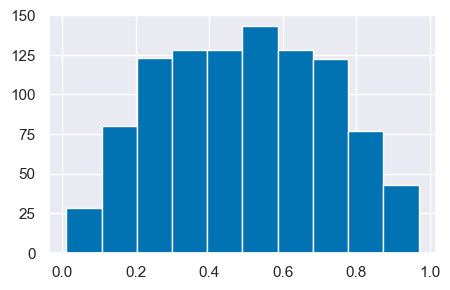

In [29]:
_ = plt.hist(rng.beta(a=2, b=2, size=1000))

### Quali parametri per la distribuzione Beta?

Se vogliamo utilizzare una distribuzione Beta per rappresentare le nostre credenze a priori sulla probabilità di successo $\theta$, dobbiamo scegliere i parametri $\alpha$ e $\beta$ della distribuzione in modo che riflettano le nostre opinioni a priori. Una strategia comune è quella di scegliere questi parametri in modo da rappresentare la nostra stima a priori del numero di successi e insuccessi, rispettivamente, su un certo numero di prove del campione.

Ad esempio, se pensiamo che, su un totale di 30 prove, ci saranno 10 successi, allora possiamo definire la distribuzione a priori come $Beta(10, 20)$, dove $\alpha=10$ rappresenta la stima a priori del numero di successi e $\beta=20$ rappresenta la stima a priori del numero di insuccessi. In questo modo, la somma $\alpha+\beta$ rappresenta il numero totale di prove nel campione.

Tuttavia, non esiste un metodo universale per scegliere i parametri della distribuzione Beta a priori, e spesso la scelta dipende dalle informazioni a nostra disposizione e dalle nostre preferenze soggettive.

Text(0, 0.5, 'Densità')

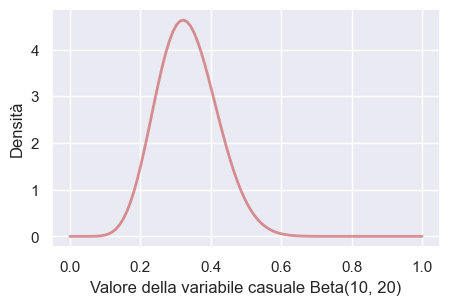

In [33]:
a = 10
b = 20
x = np.linspace(0, 1, 100)

plt.plot(x, st.beta.pdf(x, a, b), "r-", lw=2, alpha=0.6, label="beta pdf")
plt.xlabel("Valore della variabile casuale Beta(10, 20)")
plt.ylabel("Densità")

Un'alternativa per specificare la distribuzione a priori è quella di definire la mediana e un quantile della distribuzione. Ad esempio, se pensiamo che la mediana della distribuzione sia 0.25 e il quantile della distribuzione di ordine 0.9 sia 0.5, possiamo utilizzare i parametri $\alpha = 2$ e $\beta = 5$ per definire una distribuzione Beta. In questo modo stiamo esprimendo le nostre credenze a priori in termini di valori specifici della distribuzione, piuttosto che del numero di successi e insuccessi in un certo numero di prove.

Text(0, 0.5, 'Densità')

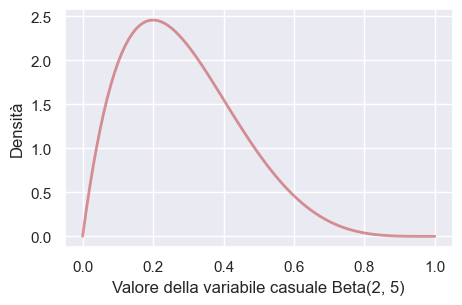

In [34]:
a = 2
b = 5
x = np.linspace(0, 1, 100)

plt.plot(x, st.beta.pdf(x, a, b), "r-", lw=2, alpha=0.6, label="beta pdf")
plt.xlabel("Valore della variabile casuale Beta(2, 5)")
plt.ylabel("Densità")

In [35]:
print(st.beta.median(2, 5))

0.26444998329566005


In [36]:
print(st.beta.ppf(0.9, 2, 5))

0.5103163065514917


## Commenti e considerazioni finali 

In questo capitolo abbiamo introdotto l'aggiornamento bayesiano per il caso di una distribuzione a priori discreta. Tuttavia, abbiamo anche anticipato alcune informazioni che si dimostreranno utili per il caso in cui viene utilizzata una distribuzione a priori continua. Nel caso di una distribuzione a priori continua, il denominatore del rapporto di Bayes include un integrale che, in generale, non può essere risolto analiticamente. Tuttavia, ci sono eccezioni, come nel caso dell'inferenza su una proporzione, in cui la distribuzione a priori è una distribuzione Beta e la verosimiglianza è binomiale. In questo caso, è possibile derivare analiticamente le proprietà della distribuzione a posteriori. Nel prossimo capitolo approfondiremo questo argomento.

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w